In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
%matplotlib inline
#%config InlineBackend.figure_format = 'svg' 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import pickle as pkl
import dtreeviz
import imodelsx.process_results
from sklearn.tree import plot_tree
import sys
import numpy as np
import viz
# import llm_tree.data
import imodelsx
import sklearn.tree
sys.path.append('../experiments/')

In [2]:
# results_dir = '/home/jxm3/research/prompting/tree-prompt/results/tree-prompt/jun4-fixed'
results_dir = '/home/jxm3/research/prompting/tree-prompt/results/tree-prompt/jun22-rt-2'
# cache_prompt_features_dir = '/home/jxm3/research/prompting/tree-prompt/cache_prompt_features'

r = imodelsx.process_results.get_results_df(results_dir, use_cached=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 592.04it/s]


In [3]:
r['max_depth'].value_counts()

max_depth
4    1
2    1
Name: count, dtype: int64

In [4]:
r.head()

,dataset_name,seed,save_dir,model_name,split_strategy,max_depth,num_prompts,checkpoint,checkpoint_prompting,verbalizer_num,...,save_dir_unique,roc_auc_train,accuracy_train,balanced_accuracy_train,roc_auc_test,accuracy_test,balanced_accuracy_test,prompts_list,prompt,feature_names
0,rotten_tomatoes,0,/home/jxm3/research/prompting/tree-prompt/resu...,tprompt,iprompt,4,15,EleutherAI/gpt-j-6B,EleutherAI/gpt-j-6B,1,...,/home/jxm3/research/prompting/tree-prompt/resu...,0.656243,0.632239,0.632239,0.626749,0.621013,0.621013,[\n\nDoes the review express admiration or pra...,\n\nDoes the review express admiration or prai...,[]
1,rotten_tomatoes,0,/home/jxm3/research/prompting/tree-prompt/resu...,tprompt,iprompt,2,15,EleutherAI/gpt-j-6B,EleutherAI/gpt-j-6B,1,...,/home/jxm3/research/prompting/tree-prompt/resu...,0.674523,0.666706,0.666706,0.654656,0.645403,0.645403,[\n\nDoes the review mention a specific aspect...,\n\nDoes the review mention a specific aspect ...,[]


In [5]:
r

,dataset_name,seed,save_dir,model_name,split_strategy,max_depth,num_prompts,checkpoint,checkpoint_prompting,verbalizer_num,...,save_dir_unique,roc_auc_train,accuracy_train,balanced_accuracy_train,roc_auc_test,accuracy_test,balanced_accuracy_test,prompts_list,prompt,feature_names
0,rotten_tomatoes,0,/home/jxm3/research/prompting/tree-prompt/resu...,tprompt,iprompt,4,15,EleutherAI/gpt-j-6B,EleutherAI/gpt-j-6B,1,...,/home/jxm3/research/prompting/tree-prompt/resu...,0.656243,0.632239,0.632239,0.626749,0.621013,0.621013,[\n\nDoes the review express admiration or pra...,\n\nDoes the review express admiration or prai...,[]
1,rotten_tomatoes,0,/home/jxm3/research/prompting/tree-prompt/resu...,tprompt,iprompt,2,15,EleutherAI/gpt-j-6B,EleutherAI/gpt-j-6B,1,...,/home/jxm3/research/prompting/tree-prompt/resu...,0.674523,0.666706,0.666706,0.654656,0.645403,0.645403,[\n\nDoes the review mention a specific aspect...,\n\nDoes the review mention a specific aspect ...,[]


In [6]:
# select a single model
# rd = r[(r['checkpoint'] == 'EleutherAI/gpt-j-6B') & (r['max_depth'] == 5)]
rd = r[r['max_depth'] == 4]
run_args = rd
run_args = rd.sort_values(by='accuracy_test', ascending=False).iloc[0]
model_name = run_args.model_name

In [7]:
print(run_args.model_name, '//', run_args.dataset_name, '//', run_args.verbalizer_num)

tprompt // rotten_tomatoes // 1


### Load an individual model

In [8]:
run_args.save_dir_unique

'/home/jxm3/research/prompting/tree-prompt/results/tree-prompt/jun22-rt-2/44fa4d9cc7e094d251a9fd261586ab7e7958ea9377bf991ee6edc1a0bbcb43da'

In [9]:
run_args.max_depth

4

'\n\nDoes the review highlight a positive aspect or praise the subject matter?'

In [19]:
print('test acc', run_args.accuracy_test, 'depth', run_args.max_depth, 'dset', run_args.dataset_name)
print('verb:', run_args.verbalizer_num)
model = pkl.load(open(join(run_args.save_dir_unique, 'model.pkl'), 'rb'))


# strip newlines
nodes = [model.root_]
while len(nodes):
    node = nodes.pop(0)
    if node is None: continue
    node.prompt = node.prompt.strip()
    nodes.append(node.child_left)
    nodes.append(node.child_right)
    # model.root_.child_right.prompt

if model_name == 'tprompt':
    dt, feature_names = imodelsx.viz.extract_sklearn_tree_from_llm_tree(model, n_classes=2, dtreeviz_dummies=False)
    print(model)
    print(feature_names)
else:
    dt = model
    feature_names = run_args.feature_names
feat_names = ['\n'.join(n.split(',')) for n in feature_names]

test acc 0.6210131332082551 depth 4 dset rotten_tomatoes
verb: 1
> Tree(max_depth=4 split_strategy=iprompt)
> ------------------------------------------------------
PromptStump(val=0.50 n=8530 prompt=Does the review express admiration or praise for the movie's content or storytelling?)
   PromptStump(val=0.39 n=2714 prompt=Does the review mention the use of cell phones as a significant aspect of the movie?)
      PromptStump(val=0.37 n=2532 prompt=Does the review primarily focus on praising the dialogue and characterizations?)
         PromptStump(val=0.20 n=1198 prompt=Does the review mention a lack of humor or emptiness in the story?)
            Neg n=1183 val=0.206
            Pos n=15 val=0.000
         PromptStump(val=0.52 n=1334 prompt=Does the review praise the movie's adaptation, style, or genre flair?)
            Neg n=201 val=0.408
            Pos n=1133 val=0.537
      PromptStump(val=0.62 n=182 prompt=Does the review express a positive opinion about the main element or pe

In [12]:
dir(model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_set_prompts_list',
 'args',
 'assert_checks',
 'checkpoint',
 'checkpoint_prompting',
 'device',
 'feature_names',
 'fit',
 'max_depth',
 'model',
 'predict',
 'predict_proba',
 'prompts_list',
 'root_',
 'split_strategy',
 'tokenizer',
 'verbose',
 'viz_tree']

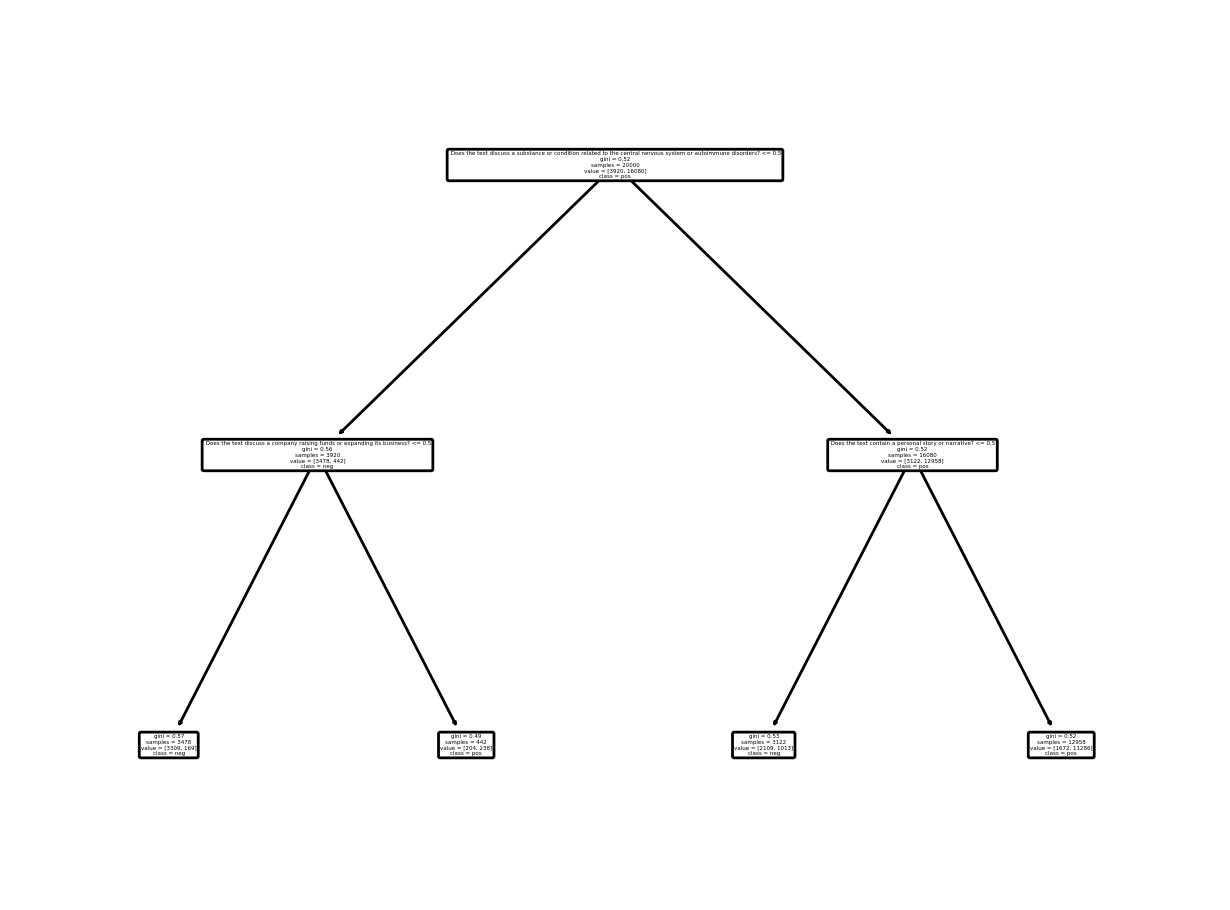

In [10]:
sklearn.tree.plot_tree(dt, feature_names=feat_names, class_names=['neg', 'pos'],
                        precision=2, rounded=True, fontsize=2)
plt.show()